The sticky air method is a good way to simulate a free surface for Eulerian approaches, provided that its parameters are chosen carefully ($C\ll1$).

2.1.1 Isostatic timescale

$C_{isost}= \frac{3}{16\pi^{3}}(\frac{L}{h_{st}})^{3}\frac{\eta_{st}}{\eta_{ch}}$


2.1.2 Stokes timescale

$C_{Stokes}= \frac{1}{16}\frac{\Delta \rho }{\rho }(\frac{h_{model}}{h_{st}})^{3}\frac{\eta_{st}}{\eta_{ch}}$


This is the case2 in the reference, like fig.7 and fig.5

### Reference

- Crameri, F., Schmeling, H., Golabek, G. J., Duretz, T., Orendt, R., Buiter, S. J. H., ... & Tackley, P. J. (2012). A comparison of numerical surface topography calculations in geodynamic modelling: an evaluation of the ‘sticky air’method. Geophysical Journal International, 189(1), 38-54.

In [1]:
import UWGeodynamics as GEO
from UWGeodynamics import visualisation as vis
from underworld import function as fn
import numpy as np
u = GEO.UnitRegistry
GEO.__version__

loaded rc file /opt/venv/lib/python3.7/site-packages/UWGeodynamics/uwgeo-data/uwgeodynamicsrc


'2.10.1-dev-164585a(master)'

In [2]:
Res_mesh = (560,340)
Res_real = [(0.,2800.),(-700,150.)] # Unit: km 

H_air = 150.* u.kilometer
D_LAB = -100.* u.kilometer
D_ma  = -700. * u.kilometer
D_plume = 100. * u.kilometer

dt = 0.005*u.megayears
fdir_output = "OPC2012_uwg_airdensity_rm_5k" 

# dt = 0.02*u.megayears
# fdir_output = "OPC2012_uwg_airdensity_rm_20k" 

In [4]:
# Scaling
ref_viscosity = 1.0e21 * u.pascal * u.second
ref_density  = 3300. * u.kilogram / u.meter**3
ref_length = 850. * u.kilometer #  modprop.boxHeight

KL = ref_length
KM = ref_density * KL**3
KT = 1.0 / (ref_viscosity / KM * KL)

GEO.scaling_coefficients["[time]"] = KT
GEO.scaling_coefficients["[length]"] = KL
GEO.scaling_coefficients["[mass]"] = KM

# Model mesh
Model = GEO.Model(elementRes=Res_mesh,
                  minCoord=(Res_real[0][0] * u.kilometer, Res_real[1][0] * u.kilometer),  
                  maxCoord=(Res_real[0][1] * u.kilometer, Res_real[1][1] * u.kilometer),
                  gravity=(0.0, -10. * u.meter / u.second**2))

Model.outputDir=fdir_output

In [5]:
GEO.scaling_coefficients

[mass],2.0266125e+21 kilogram
[length],850000.0 meter
[temperature],1.0 kelvin
[time],2.3842499999999997e-06 second
[substance],1.0 mole


In [ ]:
GEO.nd(ref_density),GEO.nd(ref_viscosity),GEO.nd(ref_length)

In [6]:
model_mid  = (Model.maxCoord[0]-Model.minCoord[0])/2

center_x = model_mid
center_y = D_ma + 300 * u.kilometer
R_plume = 50 * u.kilometer

air_Shape =  GEO.shapes.Layer2D(top=Model.top, bottom=0.*u.kilometer)
li_Shape = GEO.shapes.Layer2D(top=air_Shape.bottom,bottom=D_LAB)
ma_Shape = GEO.shapes.Layer2D(top=li_Shape.bottom, bottom=D_ma)
mp_Shape = GEO.shapes.Disk(center=(center_x , center_y),radius=R_plume)

In [7]:
air = Model.add_material(name="Stick Air", shape=air_Shape)
li  = Model.add_material(name="Lithosphere", shape=li_Shape)
ma  = Model.add_material(name="Mantle Asthenosphere", shape=ma_Shape)
mp  = Model.add_material(name="Mantle Plume", shape=mp_Shape)

In [8]:
npoints = 5000
coords = np.ndarray((npoints, 2))
coords[:, 0] = np.linspace(GEO.nd(Model.minCoord[0]), GEO.nd(Model.maxCoord[0]), npoints)
coords[:, 1] = GEO.nd(0.* u.kilometre)
surf_tracers = Model.add_passive_tracers(name="Surface",vertices=coords)

# coords = np.ndarray((npoints, 2))
# coords[:, 0] = np.linspace(GEO.nd(Model.minCoord[0]), GEO.nd(Model.maxCoord[0]), npoints)
# coords[:, 1] = GEO.nd(-H_moho)
# moho_tracers = Model.add_passive_tracers(name="Moho",vertices=coords)

In [9]:
Fig = vis.Figure(figsize=(1200,400),title="Material Field")
Fig.Points(surf_tracers, pointSize=4.0)
Fig.Points(Model.swarm, Model.materialField,fn_size=2.0,discrete=True)
Fig.save("F_Material Field.png")
Fig.show()

In [10]:
# density
air.density = -3300. * u.kilogram / u.metre**3
li.density = 0. * u.kilogram / u.metre**3 
ma.density = 0. * u.kilogram / u.metre**3
mp.density = -100. * u.kilogram / u.metre**3

In [11]:
# Viscosity
Model.minViscosity = 1e19 * u.pascal * u.second
Model.maxViscosity = 1e23 * u.pascal * u.second


air.viscosity  =  1e19 * u.pascal * u.second  
li.viscosity  =  1e23 * u.pascal * u.second                             
ma.viscosity  =  1e21 * u.pascal * u.second
mp.viscosity  =  1e20 * u.pascal * u.second

In [12]:
# Boundary conditions
Model.set_velocityBCs(left=[0., None],
                      right=[0., None],
                      bottom=[0.,0.],
                      top = [None,0.])

In [13]:
Model.solver.set_inner_method("mumps")
Model.solver.set_penalty(1e6)

GEO.rcParams["initial.nonlinear.max.iterations"] = 50
GEO.rcParams["nonlinear.max.iterations"] = 25
GEO.rcParams["initial.nonlinear.tolerance"]= 1e-4
GEO.rcParams["nonlinear.tolerance"]= 1e-3 

GEO.rcParams['swarm.particles.per.cell.2D'] = 36

In [14]:
Model.init_model(temperature=False, pressureField=True)

In [15]:
Model.run_for(4.0 * u.megayears, checkpoint_interval=1.0 *u.megayears,dt= dt)

Running with UWGeodynamics version 2.10.1-dev-164585a(master)
Options:  -Q22_pc_type gkgdiag -force_correction True -ksp_type bsscr -pc_type none -ksp_k2_type NULL -rescale_equations False -remove_constant_pressure_null_space False -change_backsolve False -change_A11rhspresolve False -restore_K False -A11_ksp_type preonly -A11_pc_type lu -A11_pc_factor_mat_solver_type mumps -scr_ksp_type fgmres -scr_ksp_rtol 1e-05 -A11_mg_active False
Step:     1 Model Time: 20000.0 year dt: 20000.0 year (2020-12-02 11:55:29)
Step:     2 Model Time: 40000.0 year dt: 20000.0 year (2020-12-02 11:55:58)
Step:     3 Model Time: 60000.0 year dt: 20000.0 year (2020-12-02 11:56:31)
Step:     4 Model Time: 80000.0 year dt: 20000.0 year (2020-12-02 11:57:01)
Step:     5 Model Time: 100000.0 year dt: 20000.0 year (2020-12-02 11:57:34)
Step:     6 Model Time: 120000.0 year dt: 20000.0 year (2020-12-02 11:58:03)
Step:     7 Model Time: 140000.0 year dt: 20000.0 year (2020-12-02 11:58:36)
Step:     8 Model Time: 16

Step:   103 Model Time: 2.0 megayear dt: 20000.0 year (2020-12-02 12:48:35)
Step:   104 Model Time: 2.1 megayear dt: 20000.0 year (2020-12-02 12:49:06)
Step:   105 Model Time: 2.1 megayear dt: 20000.0 year (2020-12-02 12:49:36)
Step:   106 Model Time: 2.1 megayear dt: 20000.0 year (2020-12-02 12:50:07)
Step:   107 Model Time: 2.1 megayear dt: 20000.0 year (2020-12-02 12:50:37)
Step:   108 Model Time: 2.1 megayear dt: 20000.0 year (2020-12-02 12:51:07)
Step:   109 Model Time: 2.2 megayear dt: 20000.0 year (2020-12-02 12:51:38)
Step:   110 Model Time: 2.2 megayear dt: 20000.0 year (2020-12-02 12:52:07)
Step:   111 Model Time: 2.2 megayear dt: 20000.0 year (2020-12-02 12:52:37)
Step:   112 Model Time: 2.2 megayear dt: 20000.0 year (2020-12-02 12:53:07)
Step:   113 Model Time: 2.2 megayear dt: 20000.0 year (2020-12-02 12:53:38)
Step:   114 Model Time: 2.3 megayear dt: 20000.0 year (2020-12-02 12:54:08)
Step:   115 Model Time: 2.3 megayear dt: 20000.0 year (2020-12-02 12:54:37)
Step:   116 

1

In [16]:
import h5py   
import matplotlib.pyplot as plt

def load_h5_tracer(fdir,tracer_name,number,dt):
    """
    load the data of the passive tracer from h5 file
    -----------
    Input:
    fdir   : *Str*, input file dir 
    tracer_name : *Str*, name of tracer
    number : *Int*, the number of file
    dt     : *Float*, [Ma], the time interval of files
    -----------
    Output:
    coord : *Np.array*
    data  : *Np.array*  
    label : *str*
    """
    fname = fdir+tracer_name +"-"+str(number)+".h5"
    label = str(number*dt) + " Ma"
    fh5   = h5py.File(fname ,'r')  
    fdata = fh5["data"][()]
    coord = fdata[:,0]
    data  = fdata[:,1]
    return coord,data,label

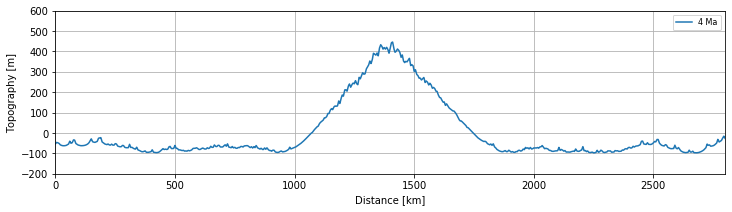

In [17]:
### not axisymmetric
tracer_name = "Surface"
number = 4
dT = 1

fig, ax = plt.subplots(1, 1, figsize=(12,3))
ax.set(xlabel='Distance [km]', ylabel='Topography [m]') 

fdir = fdir_output+"/"
coord,elev,label = load_h5_tracer(fdir,tracer_name,number,dT)
ax.plot(coord,elev*1000,label=label)

ax.set_xlim([0,2800])
ax.set_ylim([-200,600])
#ax.set_ylim([-200,1000])
ax.legend(loc = 'upper right',prop = {'size':8}) 
ax.grid()
fname = fdir_output+str(4)+"Ma"
plt.savefig(fname)